In [1]:
import torch.nn as nn 
import torch
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from intvalpy import lineqs


from src import functions
from src import trainer
from src import models
from src import utils

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


# Useful function to convert tensors to numpy arrays
def to_np(x):
    return x.cpu().detach().numpy()
def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

In [2]:
# Random seeds
training_seed = 42
test_seed = 78

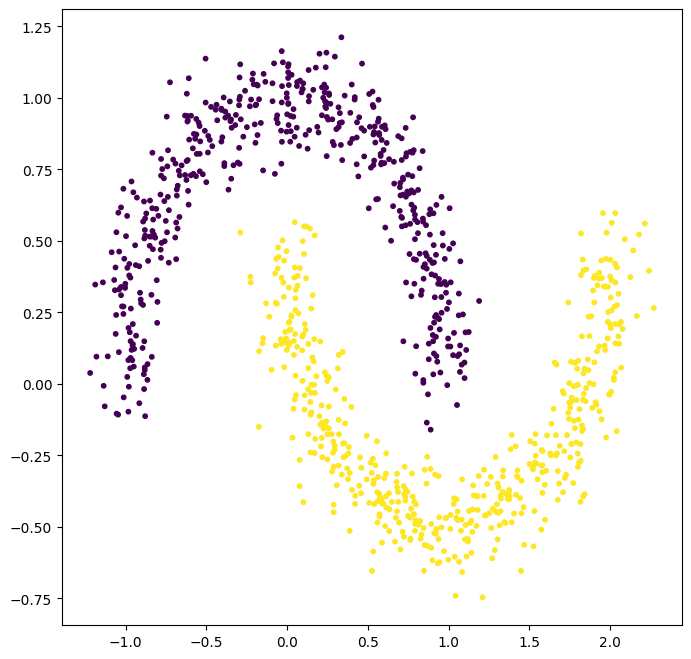

In [3]:
# Data to generate regions
X_train, y_train = make_moons(n_samples=1000, noise=0.1, random_state=training_seed)
# Convert to torch tensors
X_train, y_train = to_tensor(X_train), to_tensor(y_train)

# Visualize data
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=10)

In [4]:
# Model 
model = utils.NeuralNet(input_size = 2, num_classes = 1, hidden_sizes=[3,3])

# Training params
EPOCHS = 20000
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Try to load a pre-trained model
try:
    model.load_state_dict(torch.load('experiment_model.pth'))
    print("Model loaded successfully.")
except FileNotFoundError:
    print("Model file not found. Training a new model.")
    losses = []
    for epoch in trange(EPOCHS):
        model.train()
        optimizer.zero_grad()
        
        out = model(X_train)
        loss = criterion(out, y_train.unsqueeze(1))
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()
        
    torch.save(model.state_dict(), 'experiment_model.pth')
    np.save('experiment_losses.npy', np.array(losses))
    print("Model trained and saved successfully.")
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(losses, label='Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    ax.legend()
    plt.show()

Model loaded successfully.


In [5]:
# Accuracy for training set
model.eval()
success = 0.5
with torch.no_grad():
    out = model(X_train)
    preds = torch.sigmoid(out) > success
    accuracy = (preds.squeeze() == y_train).float().mean().item()
    print(f"Training Accuracy: {accuracy:.4f}")
    
# Generate test data with random data
X_test, y_test = make_moons(n_samples=1000, noise=0.1)

with torch.no_grad():
    out = model(to_tensor(X_test))
    preds = torch.sigmoid(out) > success
    accuracy = (preds.squeeze() == to_tensor(y_test)).float().mean().item()
    print(f"Training Accuracy: {accuracy:.4f}")

Training Accuracy: 0.8980
Training Accuracy: 0.9100


In [6]:
# Random point(s) to sample regions from
random_sample = to_np(X_train[88,:].unsqueeze(-1))  # Example: first point in the training set
print(f"Random sample point:\n{random_sample}\nshape: {random_sample.shape}")

Random sample point:
[[ 0.8931887]
 [-0.4896755]]
shape: (2, 1)


In [7]:
def regions_for_sample_point(random_sample):
    print(f"Random sample point:\n{random_sample}\nshape: {random_sample.shape}")
    
    A_random_sample, c_random_sample, [random_sample_bit_vector_list] = functions.get_inequalities(model,random_sample,return_bit_vec_list=True, input_dimension=2 )
        
    indexes_for_active_bits_random_sample, stats = functions.active_bits_index_2 (A_random_sample[0],c_random_sample[0].reshape(-1) )
    
    polytope_list, active_bit_count_list  = functions.get_polytope_list(random_sample_bit_vector_list, indexes_for_active_bits_random_sample, input_dimension=2, model=model)
    
    bit_string_list_from_alg = polytope_list

    def divide_column_vector(column_vector):
        return np.array_split(column_vector, 2)

    list_of_lists_of_column_vectors_alg = [divide_column_vector(column_vector) for column_vector in bit_string_list_from_alg]
    
    A_alg, c_alg = functions.get_inequalities(model,list_of_lists_of_column_vectors_alg, is_input_sample=False,return_bit_vec_list=False, input_dimension=2)
    # print(f"Length of A_alg: {len(A_alg)}")
    
    verticles_list_alg = []

    bound = 2.5


    def find_verticles(A, c, bound):
        # Find the boundaries of the polytope defined by Ax <= c
        for A, c in zip (A_alg, c_alg):
            verticles = lineqs(-A, -c, title='Solution', color='red', save=False, show=False, bounds = [[-bound, -bound], [bound, bound]])
            verticles_list_alg.append(verticles)
        # return verticles_list_alg
    errors = 0
    try:
        find_verticles(A_alg, c_alg,bound)
    except IndexError:
        errors += 1
    # print(f"Encountered {errors} errors")
    
    # bound = 3

    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    patches = []
    num_polygons = len(verticles_list_alg)
    colors = [np.random.randint(1, 300) for i in range(num_polygons)]
    cmap = matplotlib.colormaps['rainbow']

    polytopes_within_boundaries = 0  # Counter for polytopes within boundaries


    # for i in range(num_polygons):
    for i in range(num_polygons):
        vertices_i = verticles_list_alg[i]
        
        # Check if any vertex falls within the boundaries
        vertices_within_boundaries = any(-bound <= coord[0] <= bound and -bound <= coord[1] <= bound for coord in vertices_i)
    #     clipped_vertices = clip_vertices(vertices_i.tolist(),bound)
        if vertices_within_boundaries:
            polygon = Polygon(xy=vertices_i,
                            closed=True,
                            facecolor=cmap(colors[i]),
                            edgecolor='black',
                            #   label=np.transpose(bit_string_list_from_alg[i])[0],
                            )
            ax.add_patch(polygon)
        
            patches.append(polygon)
            
            polytopes_within_boundaries += 1

            
            

    ax.set_xlim([-bound, bound])
    ax.set_ylim([-bound, bound])
    # Show random sample point
    ax.scatter(random_sample[0], random_sample[1], color='black', s=50, label='Random Sample', zorder=5)

    p = PatchCollection(patches, cmap=matplotlib.cm.gist_rainbow, alpha=0.8)
    # np.random.seed(10)
    colors = [np.random.randint(1, 1000) for i in range(len(patches))]
    plt.show()

    print(f"The number of polytopes within the boundaries is: {polytopes_within_boundaries}")
    return verticles_list_alg


Random sample point:
[[-0.05146968]
 [ 0.44419864]]
shape: (2, 1)


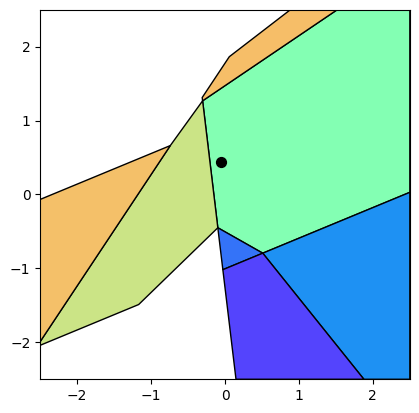

The number of polytopes within the boundaries is: 7
Random sample point:
[[2.2415082]
 [0.3956499]]
shape: (2, 1)


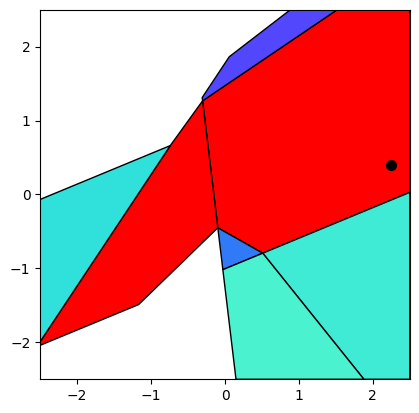

The number of polytopes within the boundaries is: 7
Random sample point:
[[ 0.259317  ]
 [-0.15595199]]
shape: (2, 1)


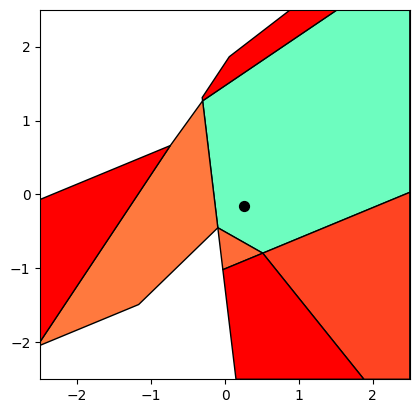

The number of polytopes within the boundaries is: 7
Random sample point:
[[-0.9672013 ]
 [ 0.26367208]]
shape: (2, 1)


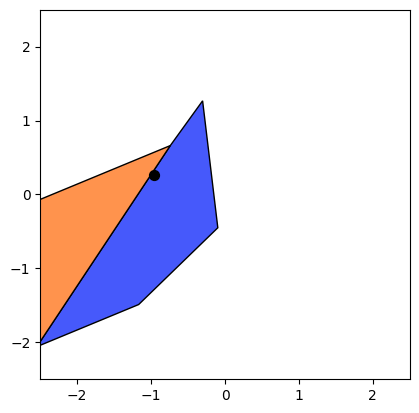

The number of polytopes within the boundaries is: 2
Random sample point:
[[0.25793335]
 [0.02355161]]
shape: (2, 1)


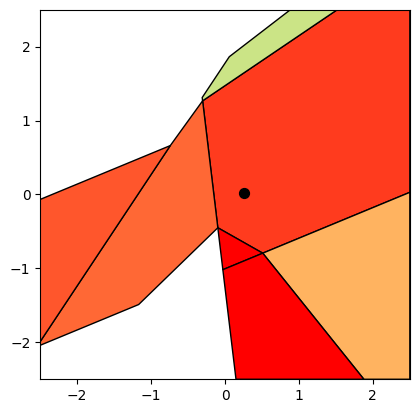

The number of polytopes within the boundaries is: 7
Random sample point:
[[1.8528122 ]
 [0.40134278]]
shape: (2, 1)


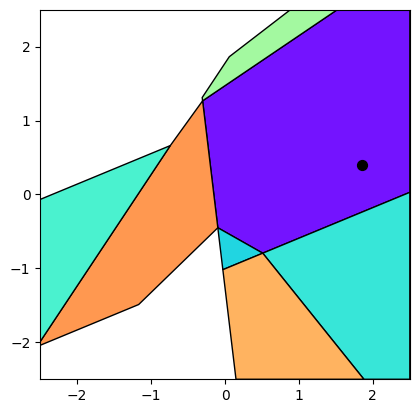

The number of polytopes within the boundaries is: 7
Random sample point:
[[ 1.8010155 ]
 [-0.29036078]]
shape: (2, 1)


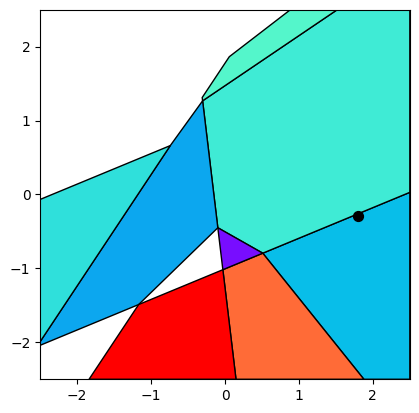

The number of polytopes within the boundaries is: 8


In [10]:
list_of_lists_of_vertices = []
for idx in [0, 43, 56, 998, 548, 945, 888]:
    local_list = regions_for_sample_point(to_np(X_train[idx,:].unsqueeze(-1)))
    list_of_lists_of_vertices.append(local_list)

In [ ]:
# from itertools import zip_longest
# list_of_lists_of_vertices[6]

# vertices = np.vstack([v_array for v_array in list_of_lists_of_vertices])

# arr_filled = [list(tpl) for tpl in zip(*zip_longest(*list_of_lists_of_vertices))]
# vertices = np.vstack([v_array for v_array in arr_filled])
# vertices = np.asarray(arr_filled, dtype="object")


In [80]:
list_of_vertices = []
for list_of_local_vertices in list_of_lists_of_vertices:
    for local_vertex in list_of_local_vertices:
        list_of_vertices.append(local_vertex)

In [90]:
len(list_of_vertices)

45

In [84]:
list_of_vertices_tuples = [tuple(i) for i in list_of_vertices]

In [89]:
from collections import Counter

Counter(map(tuple,list_of_vertices))

TypeError: unhashable type: 'numpy.ndarray'

In [68]:
unique_vertices = set(map(tuple,list_of_vertices))

In [77]:
vertices_arr = np.asarray(list(unique_vertices))

In [79]:
vertices_arr

array([[-2.54654214, -2.05924002],
       [-0.74016814,  0.66161927],
       [-1.16835181, -1.48893972],
       [ 2.5       ,  0.02903794],
       [-0.30865113,  1.31159379],
       [-0.02938264, -1.01763003],
       [ 0.51041905, -0.79425808]])

IndexError: invalid index to scalar variable.

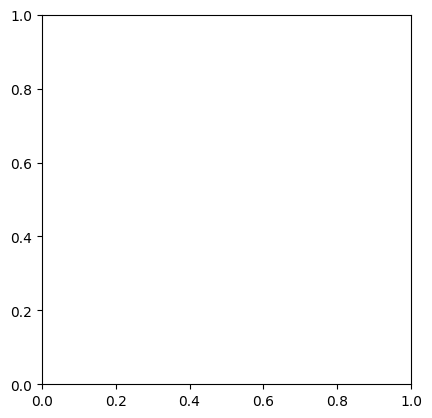

In [78]:
bound = 2

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
patches = []
num_polygons = len(vertices_arr)
colors = [np.random.randint(1, 300) for i in range(num_polygons)]
cmap = matplotlib.colormaps['rainbow']

polytopes_within_boundaries = 0  # Counter for polytopes within boundaries


# for i in range(num_polygons):
for i in range(num_polygons):
    vertices_i = vertices_arr[i]
    
    # Check if any vertex falls within the boundaries
    vertices_within_boundaries = any(-bound <= coord[0] <= bound and -bound <= coord[1] <= bound for coord in vertices_i)
#     clipped_vertices = clip_vertices(vertices_i.tolist(),bound)
    if vertices_within_boundaries:
        polygon = Polygon(xy=vertices_i,
                        closed=True,
                        facecolor=cmap(colors[i]),
                        edgecolor='black',
                        #   label=np.transpose(bit_string_list_from_alg[i])[0],
                        )
        ax.add_patch(polygon)
    
        patches.append(polygon)
        
        polytopes_within_boundaries += 1

        
        

ax.set_xlim([-bound, bound])
ax.set_ylim([-bound, bound])
# Show random sample point
ax.scatter(random_sample[0], random_sample[1], color='black', s=50, label='Random Sample', zorder=5)

p = PatchCollection(patches, cmap=matplotlib.cm.gist_rainbow, alpha=0.8)
# np.random.seed(10)
colors = [np.random.randint(1, 1000) for i in range(len(patches))]
plt.show()

print(f"The number of polytopes within the boundaries is: {polytopes_within_boundaries}")

In [ ]:
# A_random_sample, c_random_sample, [random_sample_bit_vector_list] = functions.get_inequalities(model,random_sample,return_bit_vec_list=True, input_dimension=2 )
        
# indexes_for_active_bits_random_sample, stats = functions.active_bits_index_2 (A_random_sample[0],c_random_sample[0].reshape(-1) )

In [ ]:
# polytope_list, active_bit_count_list  = functions.get_polytope_list(random_sample_bit_vector_list, indexes_for_active_bits_random_sample, input_dimension=2, model=model)

In [ ]:
# bit_string_list_from_alg = polytope_list

# def divide_column_vector(column_vector):
#     return np.array_split(column_vector, 2)

# list_of_lists_of_column_vectors_alg = [divide_column_vector(column_vector) for column_vector in bit_string_list_from_alg]

In [ ]:
# A_alg, c_alg = functions.get_inequalities(model,list_of_lists_of_column_vectors_alg, is_input_sample=False,return_bit_vec_list=False, input_dimension=2)
# len(A_alg)


17

In [ ]:
# verticles_list_alg = []

# bound = 2


# def find_verticles(A, c, bound):
#     # Find the boundaries of the polytope defined by Ax <= c
#     for A, c in zip (A_alg, c_alg):
#         verticles = lineqs(-A, -c, title='Solution', color='red', save=False, show=False, bounds = [[-bound, -bound], [bound, bound]])
#         verticles_list_alg.append(verticles)
#     # return verticles_list_alg
# print(len(verticles_list_alg))
# # counter = 1
# # c_max = 500
# # while counter <= c_max:
# #     try:
# #         find_verticles(A_alg, c_alg, bound)
# #         print(f"Found {len(verticles_list_alg)} vertices\nBound: {bound}\nCounter: {counter}")
# #         break
# #     except IndexError:
        
# #         counter += 1
# #         bound = 2**counter
# #         verticles_list_alg = []
# #     if counter == c_max:
# #         print(f"Failed to find vertices after {c_max} attempts. Last bound was: {bound:.2e}")
# errors = 0
# try:
#     find_verticles(A_alg, c_alg,3)
# except IndexError:
#     errors += 1
# print(len(verticles_list_alg))
# print(f"Encountered {errors} errors")

0
7
Encountered 1 errors


In [ ]:
# print(len(verticles_list_alg))
# print(verticles_list_alg)

7
[array([[ 3.        ,  0.23593981],
       [ 0.51041905, -0.79425808],
       [-0.09740839, -0.45026493],
       [-0.30330391,  1.2669956 ],
       [ 2.25734961,  3.        ],
       [ 3.        ,  3.        ]]), array([[ 0.51041905, -0.79425808],
       [ 3.        ,  0.23593981],
       [ 3.        , -3.        ],
       [ 2.27957477, -3.        ]]), array([[-2.54654214, -2.05924002],
       [-0.74016814,  0.66161927],
       [-0.30330391,  1.2669956 ],
       [-0.09740839, -0.45026493],
       [-1.16835181, -1.48893972]]), array([[ 0.51041905, -0.79425808],
       [-0.02938264, -1.01763003],
       [-0.09740839, -0.45026493]]), array([[-0.30865113,  1.31159379],
       [ 0.05782844,  1.86360536],
       [ 1.53441721,  3.        ],
       [ 2.25734961,  3.        ],
       [-0.30330391,  1.2669956 ]]), array([[-0.02938264, -1.01763003],
       [ 0.51041905, -0.79425808],
       [ 2.27957477, -3.        ],
       [ 0.20829889, -3.        ]]), array([[-0.74016814,  0.66161927],
     

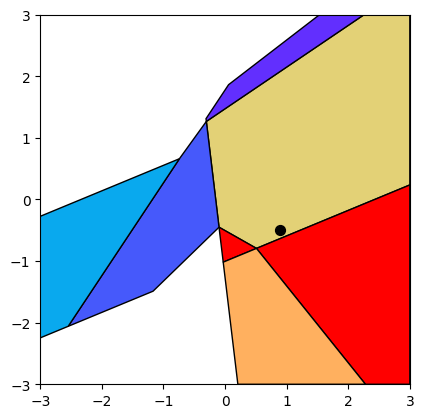

The number of polytopes within the boundaries is: 7


In [ ]:
# bound *= 1.1
# bound = 3

# fig = plt.figure()
# ax = fig.add_subplot(111, aspect='equal')
# patches = []
# num_polygons = len(verticles_list_alg)
# colors = [np.random.randint(1, 300) for i in range(num_polygons)]
# cmap = matplotlib.colormaps['rainbow']
# #
# polytopes_within_boundaries = 0  # Counter for polytopes within boundaries


# # for i in range(num_polygons):
# for i in range(num_polygons):
#     vertices_i = verticles_list_alg[i]
    
#     # Check if any vertex falls within the boundaries
#     vertices_within_boundaries = any(-bound <= coord[0] <= bound and -bound <= coord[1] <= bound for coord in vertices_i)
# #     clipped_vertices = clip_vertices(vertices_i.tolist(),bound)
#     if vertices_within_boundaries:
#         polygon = Polygon(xy=vertices_i,
#                           closed=True,
#                           facecolor=cmap(colors[i]),
#                           edgecolor='black',
#                         #   label=np.transpose(bit_string_list_from_alg[i])[0],
#                          )
#         ax.add_patch(polygon)
    
#         patches.append(polygon)
        
#         polytopes_within_boundaries += 1

        
        

# ax.set_xlim([-bound, bound])
# ax.set_ylim([-bound, bound])
# # Show random sample point
# ax.scatter(random_sample[0], random_sample[1], color='black', s=50, label='Random Sample', zorder=5)

# p = PatchCollection(patches, cmap=matplotlib.cm.gist_rainbow, alpha=0.8)
# # np.random.seed(10)
# colors = [np.random.randint(1, 1000) for i in range(len(patches))]
# plt.show()

# print(f"The number of polytopes within the boundaries is: {polytopes_within_boundaries}")